In [ ]:
!pip install tensorflow==2.10.1
!pip install patchify

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import random
import itertools
import tensorflow as tf
from matplotlib import gridspec
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
from sklearn.metrics import confusion_matrix

2023-08-30 19:34:57.805477: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
print(tf.__version__)
print(cv2.__version__)

2.10.1
4.8.0


In [4]:
hp = {}
hp['image_size'] = 512
hp['num_channels'] = 3
hp['patch_size'] = 64
hp['num_patches'] = int(hp['image_size']**2) // (hp["patch_size"]**2)
hp["flat_patches_shape"] = (hp["num_patches"], hp['patch_size']*hp['patch_size']*hp["num_channels"])
hp['batch_size'] = 32
hp['lr'] = 1e-4
hp["num_epochs"] = 30
hp['num_classes'] = 3
hp["num_layers"] = 12
hp["hidden_dim"] = 256
hp["mlp_dim"] = 3072
hp['num_heads'] = 12
hp['dropout_rate'] = 0.1
hp['class_names'] = ["lung_aca", "lung_n", "lung_scc"]

In [5]:
train_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Train/*"
valid_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Val/*"
test_path = "/kaggle/input/lung-and-colon-cancer-dataset-splitted/lung/lung/Test/*"

model_path = "/kaggle/working/ViT_for_lung_cancer_classification.h5"
csv_path = "/kaggle/working/ViT_for_lung_cancer_classification.csv"

In [6]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [7]:
def load_data(path, split=0.1):
    images = shuffle(glob(os.path.join(path, "*.jpeg")))
    return images

In [37]:
def process_image(path):
    #decode the path
    path = path.decode()
    #read image
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    #resize the image
    image = cv2.resize(image, [512, 512])
    #scale the image
    image = image / 255.0
    #change the data type of image
    image = image.astype(np.float32)

    #labeling the image
    class_name = path.split("/")[-2]
    class_idx = hp['class_names'].index(class_name)
    class_idx = np.array(class_idx, dtype=np.int32)

    return image, class_idx

In [44]:
def parse(path):
    image, labels = tf.numpy_function(process_image, [path], (tf.float32, tf.int32))
    labels = tf.one_hot(labels, 3)
    image.set_shape([512, 512, 3])
    labels.set_shape(3)
  
    return image, labels

In [45]:
#tensorflow dataset
def tf_dataset(images, batch=32):
    dataset = tf.data.Dataset.from_tensor_slices((images))
    dataset = dataset.map(parse)
    dataset = dataset.batch(hp['batch_size'])
    dataset = dataset.prefetch(8)
    return dataset

# Data Preprcoessing

In [46]:
#load the data
train_x = load_data(train_path)
valid_x = load_data(valid_path)
test_x = load_data(test_path)

In [47]:
print(f'Train:{len(train_x)}  Valid:{len(valid_x)}  Test:{len(test_x)}')

Train:11250  Valid:1875  Test:1875


In [12]:
create_dir("/kaggle/working/file")

In [15]:
process_image_label(train_x[0])

# Visualize the histopathology image

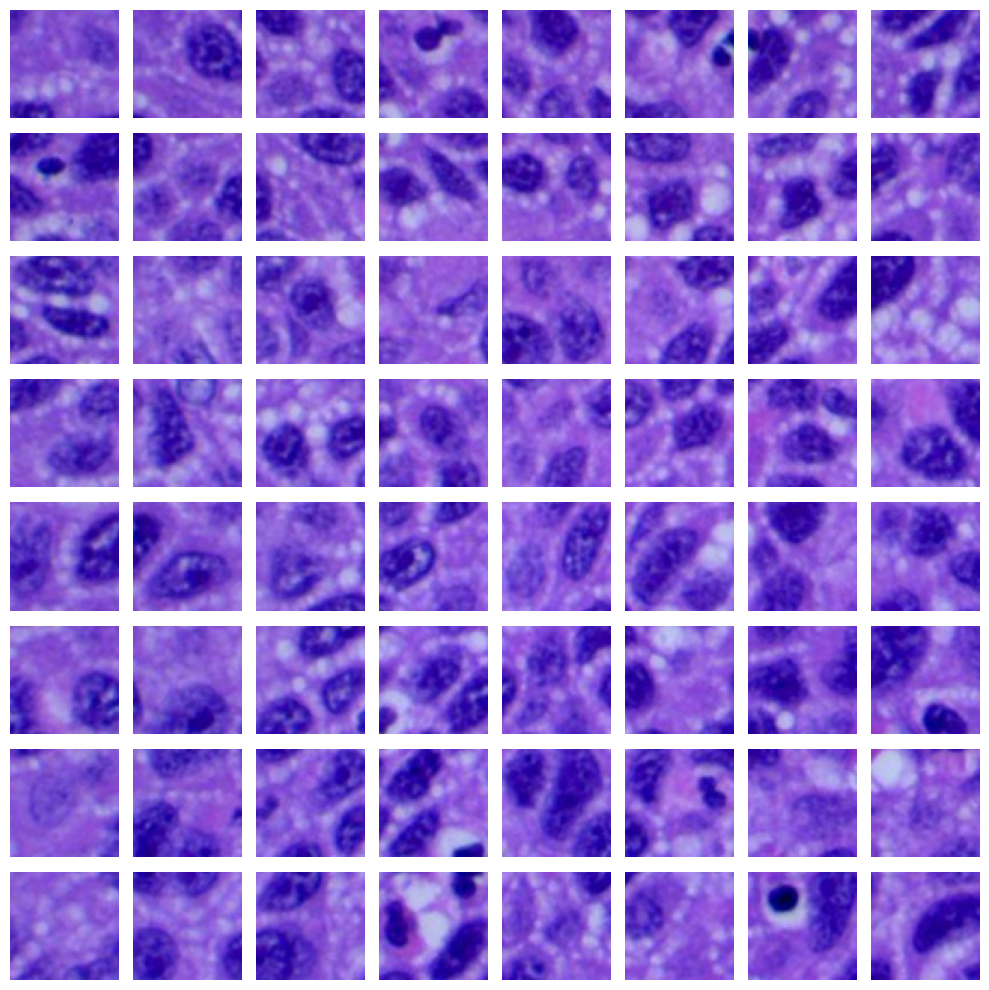

In [19]:
# Path to the folder containing your images
image_folder = "/kaggle/working/file"

# Get a list of image file names
image_files = os.listdir(image_folder)
image_files = sorted(image_files, key=lambda x: int(x.split('_')[1].split('.')[0]))
# Create a 8x8 grid of subplots
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(8, 8)

for i, img_file in enumerate(image_files[:64]):
    # Load the image using PIL
    img_path = os.path.join(image_folder, img_file)
    img = Image.open(img_path)
    
    # Create a subplot
    ax = plt.subplot(gs[i])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

# Data Pipeline

In [48]:
train_ds = tf_dataset(train_x)
valid_ds = tf_dataset(valid_x)
test_ds = tf_dataset(test_x)

In [49]:
for i,j in train_ds:
    print(i.shape, j.shape)
    break

(32, 512, 512, 3) (32, 3)


# Model | ViT with ResNet

In [50]:
class ClassToken(layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32), 
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        #reshape
        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        #change data type
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls   

In [51]:
def cnn_model(x):
    
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(x)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c1)
    c1 = layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c1)
    c1 = layers.MaxPooling2D((2, 2), strides=(2, 2))(c1)
    
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c1)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c2)
    c2 = layers.Conv2D(32, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c2)
    c2 = layers.MaxPooling2D((2,2), strides=(2,2))(c2)
    
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c2)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c3)
    c3 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c3)
    c3 = layers.MaxPooling2D((2,2), strides=(2,2))(c3)
    
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c3)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c4)
    c4 = layers.Conv2D(64, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c4)
    c4 = layers.MaxPooling2D((2,2), strides=(2,2))(c4)
    
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c4)
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c5)
    c5 = layers.Conv2D(128, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c5)
    c5 = layers.MaxPooling2D((2,2), strides=(2,2))(c5)
    
    c6 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c5)
    c6 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c6)
    c6 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c6)
    c6 = layers.MaxPooling2D((2,2), strides=(2,2))(c5)
    
    c7 = layers.Conv2D(256, (3,3), activation='relu', padding='same', strides=(1,1), kernel_initializer='he_normal')(c6)

    #print(c7.shape)
    return c7

In [52]:
def mlp(x, cf):
    x = layers.Dense(cf['mlp_dim'], activation='gelu')(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    x = layers.Dense(cf['hidden_dim'])(x)
    x = layers.Dropout(cf['dropout_rate'])(x)
    return x

In [53]:
def transformer_encoder(x, cf):
    skip_1 = x
    x = layers.LayerNormalization()(x)
    x = layers.MultiHeadAttention(num_heads=cf['num_heads'], key_dim=cf['hidden_dim'])(x,x)
    x = layers.Add()([x, skip_1])
    
    skip_2 = x
    x = layers.LayerNormalization()(x)
    x = mlp(x, cf)
    x = layers.Add()([x, skip_2])
    
    return x

In [54]:
 def CNN_ViT(hp):
    input_shape = (hp['image_size'], hp['image_size'], hp['num_channels'])
    inputs = layers.Input(input_shape)
    output = cnn_model(inputs)

    patch_embed = layers.Conv2D(hp['hidden_dim'], kernel_size=(hp['patch_size']), padding='same')(output)
    #print(patch_embed.shape)
    _, h, w, f = output.shape
    patch_embed = layers.Reshape((h*w,f))(output)

    #Position Embedding
    positions = tf.range(start=0, limit=hp['num_patches'], delta=1)
    pos_embed = layers.Embedding(input_dim=hp['num_patches'], output_dim=hp['hidden_dim'])(positions)

    #Patch + Position Embedding
    embed = patch_embed + pos_embed
    
    #Token
    token = ClassToken()(embed)
    x = layers.Concatenate(axis=1)([token, embed]) #(None, 257, 256)
    
    #Transformer encoder
    for _ in range(hp['num_layers']):
        x = transformer_encoder(x, hp)
    
    
    x = layers.LayerNormalization()(x)
    x = x[:, 0, :]
    x = layers.Dense(hp['num_classes'], activation='softmax')(x)
    
    model = Model(inputs, x)
    return model

In [55]:
ViT = CNN_ViT(hp)

In [56]:
ViT.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_21 (Conv2D)             (None, 512, 512, 16  2320        ['conv2d_20[0][0]']              
                                )                                                           

In [57]:
ViT.compile(loss='categorical_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(hp['lr'], clipvalue=1.0),
              metrics=['acc']
             )

In [58]:
cbacks = [
    tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7),
    tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
]

# Training

In [59]:
ViT.fit(
        train_ds,
        epochs=20,
        validation_data=valid_ds,
        callbacks=cbacks
    )

Epoch 1/20
352/352 [==============================] - ETA: 0s - loss: 0.4868 - acc: 0.8014
Epoch 1: val_loss improved from inf to 0.46297, saving model to /kaggle/working/ViT_for_lung_cancer_classification.h5
352/352 [==============================] - 340s 903ms/step - loss: 0.4868 - acc: 0.8014 - val_loss: 0.4630 - val_acc: 0.8064 - lr: 1.0000e-04
Epoch 2/20
352/352 [==============================] - ETA: 0s - loss: 0.2099 - acc: 0.9203
Epoch 2: val_loss improved from 0.46297 to 0.19203, saving model to /kaggle/working/ViT_for_lung_cancer_classification.h5
352/352 [==============================] - 206s 584ms/step - loss: 0.2099 - acc: 0.9203 - val_loss: 0.1920 - val_acc: 0.9269 - lr: 1.0000e-04
Epoch 3/20
352/352 [==============================] - ETA: 0s - loss: 0.1737 - acc: 0.9340
Epoch 3: val_loss did not improve from 0.19203
352/352 [==============================] - 201s 570ms/step - loss: 0.1737 - acc: 0.9340 - val_loss: 0.2559 - val_acc: 0.9120 - lr: 1.0000e-04
Epoch 4/20
352

# Testing Model

In [61]:
ViT.evaluate(test_ds)

59/59 [==============================] - 41s 689ms/step - loss: 0.0893 - acc: 0.9739


[0.08925846964120865, 0.9738666415214539]

In [62]:
#plot confusion matrix
def plt_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_mark = np.arange(len(classes))
    plt.xticks(tick_mark, classes, rotation=45)
    plt.yticks(tick_mark, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.axis]
        print("normalized confusion matrix")

    else:
        print("confusion matrix without normalization")

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.xlabel("predicted label")
        plt.ylabel("True label")

In [64]:
#prediction
prediction = ViT.predict(test_ds, verbose=0)

In [65]:
#scale the predicted value
np.around(prediction)

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [66]:
#get the max value 
y_pred_classes = np.argmax(prediction, axis=1)

In [67]:
#function for get labels of test set
def get_test_data_class(test_path):
    names = []
    for i in test_path:
        name = i.split("/")[-2]
        name_idx = hp['class_names'].index(name)
        names.append(name_idx)
    names = np.array(names, dtype=np.int32)
    return names

In [68]:
classes = get_test_data_class(test_x)

In [69]:
#confusion matrix
cm = confusion_matrix(y_true=classes, y_pred=y_pred_classes)

confusion matrix without normalization


/tmp/ipykernel_28/3594088673.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


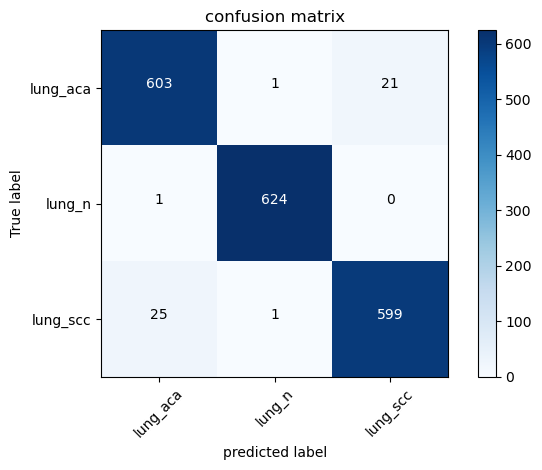

In [70]:
plt_confusion_matrix(cm=cm, classes=hp['class_names'], title="confusion matrix", )